# Import



In [41]:
### Import des bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ClassificationReport
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import pandas as pd

### Configuration des options pour les graphiques
%matplotlib inline
sns.set(style="whitegrid")


## Merged data

In [31]:

### Charger les datasets
# dataframe depuis kaggle
heart_data_1 = pd.read_csv('../heart_disease_uci.csv')
# dataframe depuis source
heart_data_2 = pd.read_csv('../HeartDiseaseUCI.csv')

### Afficher un aperçu des données
display(heart_data_1.head())
display(heart_data_2.head())

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [6]:
print(f"heart data 1 shape{heart_data_1.shape}")
print(f"heart data 2 shape{heart_data_2.shape}")

heart data 1 shape(920, 16)
heart data 2 shape(303, 15)


In [32]:


# Step 1: Rename specific columns in heart_data_1 to match heart_data_2
# Renaming 'id' to 'Unnamed: 0' and 'thalch' to 'thalach'
heart_data_1 = heart_data_1.rename(columns={'id': 'Unnamed: 0', 'thalch': 'thalach'})

# Step 2: Define mappings for categorical variables
# Chest pain type (cp)
cp_mapping = {
    "typical angina": 1,
    "atypical angina": 2,
    "non-anginal": 3,
    "asymptomatic": 4
}

# Resting ECG results (restecg)
restecg_mapping = {
    "normal": 0,
    "lv hypertrophy": 1,
    "st-t abnormality": 2
}

# Slope of the peak exercise ST segment (slope)
slope_mapping = {
    "upsloping": 1,
    "flat": 2,
    "downsloping": 3
}

# Thalassemia (thal)
thal_mapping = {
    "normal": 3,
    "fixed defect": 6,
    "reversable defect": 7
}

# Mapping for sex
sex_mapping = {
    "Male": 1,
    "Female": 0
}

# Step 3: Apply mappings to transform heart_data_1
heart_data_1['cp'] = heart_data_1['cp'].map(cp_mapping)
heart_data_1['restecg'] = heart_data_1['restecg'].map(restecg_mapping)
heart_data_1['slope'] = heart_data_1['slope'].map(slope_mapping)
heart_data_1['thal'] = heart_data_1['thal'].map(thal_mapping)
heart_data_1['sex'] = heart_data_1['sex'].map(sex_mapping)

# Step 4: Convert boolean columns to integers (0 and 1)
heart_data_1['fbs'] = heart_data_1['fbs'].astype(float)
heart_data_1['exang'] = heart_data_1['exang'].astype(float)

# Step 5: Ensure columns in heart_data_1 match the columns in heart_data_2
heart_data_1 = heart_data_1[heart_data_2.columns]

# Step 6: Merge the two DataFrames and drop duplicates
merged_df = pd.concat([heart_data_1, heart_data_2], ignore_index=True)
merged_df = merged_df.drop_duplicates()

# Display the first few rows of the merged DataFrame
print(merged_df.head())


   Unnamed: 0  age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  \
0           1   63    1   1     145.0  233.0  1.0      1.0    150.0    0.0   
1           2   67    1   4     160.0  286.0  0.0      1.0    108.0    1.0   
2           3   67    1   4     120.0  229.0  0.0      1.0    129.0    1.0   
3           4   37    1   3     130.0  250.0  0.0      0.0    187.0    0.0   
4           5   41    0   2     130.0  204.0  0.0      1.0    172.0    0.0   

   oldpeak  slope   ca  thal  num  
0      2.3    3.0  0.0   6.0    0  
1      1.5    2.0  3.0   3.0    2  
2      2.6    2.0  2.0   7.0    1  
3      3.5    3.0  0.0   3.0    0  
4      1.4    1.0  0.0   3.0    0  


### Explication rapide des colonnes et valeurs

Unnamed: 0 : Identifiant unique de chaque observation.
age : Âge du patient.
sex : Sexe du patient (1 = Homme, 0 = Femme).
cp : Type de douleur thoracique (chest pain type) :

    1 : Angine typique
    2 : Angine atypique
    3 : Douleur non angineuse
    4 : Asymptomatique

trestbps : Pression artérielle au repos en mm Hg.
chol : Niveau de cholestérol sérique en mg/dl.
fbs : Glycémie à jeun > 120 mg/dl (1 = Vrai ; 0 = Faux).
restecg : Résultats de l'électrocardiogramme au repos :

    0 : Normal
    1 : Hypertrophie ventriculaire gauche (lv hypertrophy)
    2 : Anomalie de ST-T

thalach : Fréquence cardiaque maximale atteinte.
exang : Angine induite par l'exercice (1 = Oui ; 0 = Non).
oldpeak : Dépression de ST induite par l'exercice par rapport au repos.
slope : Pente du segment ST lors du pic d'exercice :

    1 : Pente montante (upsloping)
    2 : Pente plate (flat)
    3 : Pente descendante (downsloping)

ca : Nombre de vaisseaux principaux (0-3) colorés par fluoroscopie.
thal : Résultats du test thalium :

    3 : Normal
    6 : Défaut fixe (fixed defect)
    7 : Défaut réversible (reversable defect)

num : Indicateur de présence de maladie cardiaque (0 = Absence ; 1-4 = Présence).

In [33]:
merged_df.shape

(1072, 15)

Valeurs manquantes par colonne :
 Unnamed: 0      0
age             0
sex             0
cp              0
trestbps       59
chol           30
fbs            90
restecg         2
thalach        55
exang          55
oldpeak        62
slope         309
ca            612
thal          487
num             0
dtype: int64

Statistiques descriptives :
        Unnamed: 0          age          sex           cp     trestbps  \
count  1072.000000  1072.000000  1072.000000  1072.000000  1013.000000   
mean    415.123134    53.843284     0.774254     3.247201   132.465943   
std     272.047326     9.356996     0.418268     0.939581    18.965125   
min       1.000000    28.000000     0.000000     1.000000     0.000000   
25%     172.750000    47.750000     1.000000     3.000000   120.000000   
50%     384.500000    55.000000     1.000000     4.000000   130.000000   
75%     652.250000    60.000000     1.000000     4.000000   140.000000   
max     920.000000    77.000000     1.000000     4.000000   20

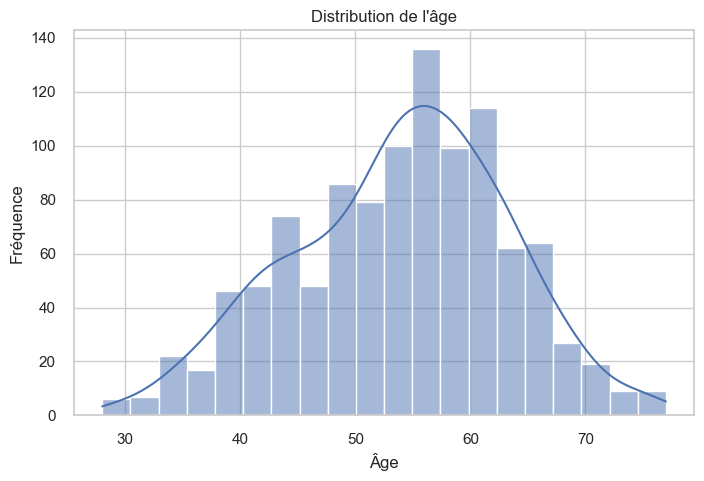

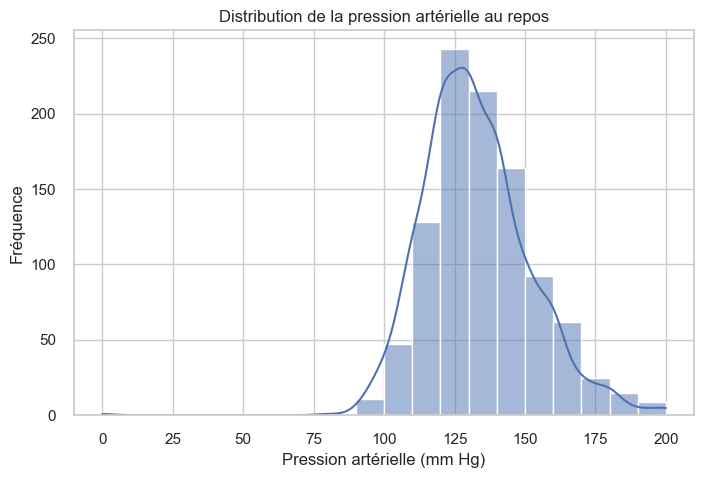

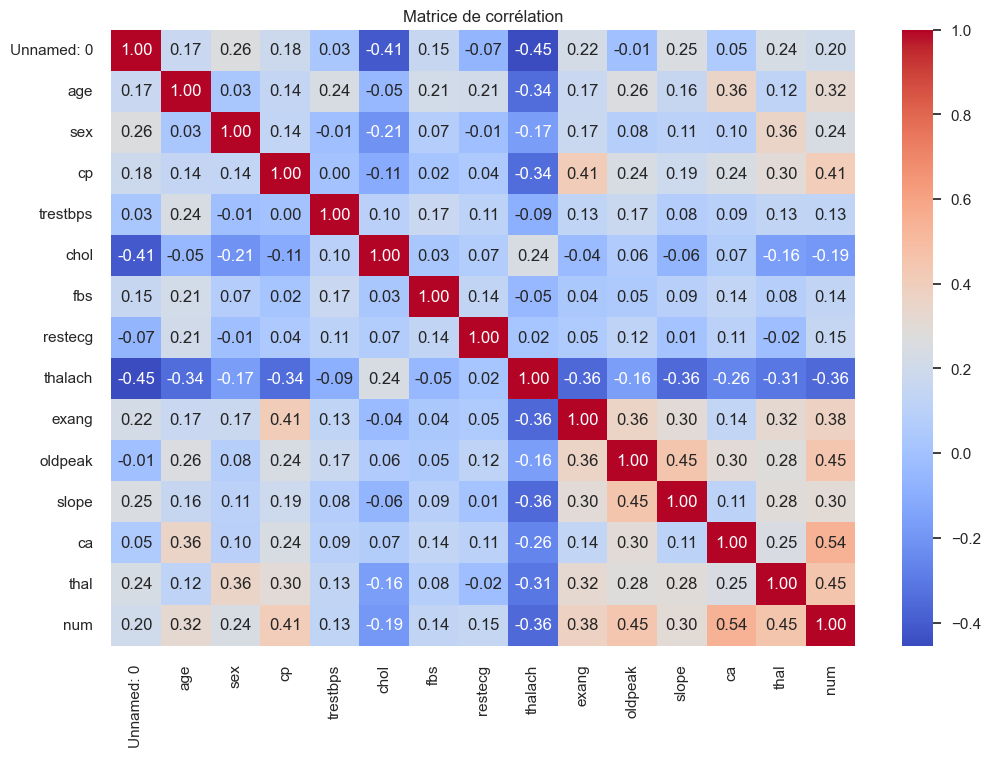

In [35]:
# Vérifier les valeurs manquantes
print("Valeurs manquantes par colonne :\n", merged_df.isnull().sum())

# Afficher les statistiques descriptives
print("\nStatistiques descriptives :")
print(merged_df.describe())

# Visualiser la distribution de l'âge
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['age'], bins=20, kde=True)
plt.title("Distribution de l'âge")
plt.xlabel("Âge")
plt.ylabel("Fréquence")
plt.show()

# Visualiser la distribution de la pression artérielle au repos
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['trestbps'], bins=20, kde=True)
plt.title("Distribution de la pression artérielle au repos")
plt.xlabel("Pression artérielle (mm Hg)")
plt.ylabel("Fréquence")
plt.show()

# Visualiser la corrélation entre les variables
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

### Plotting


#### Numérique


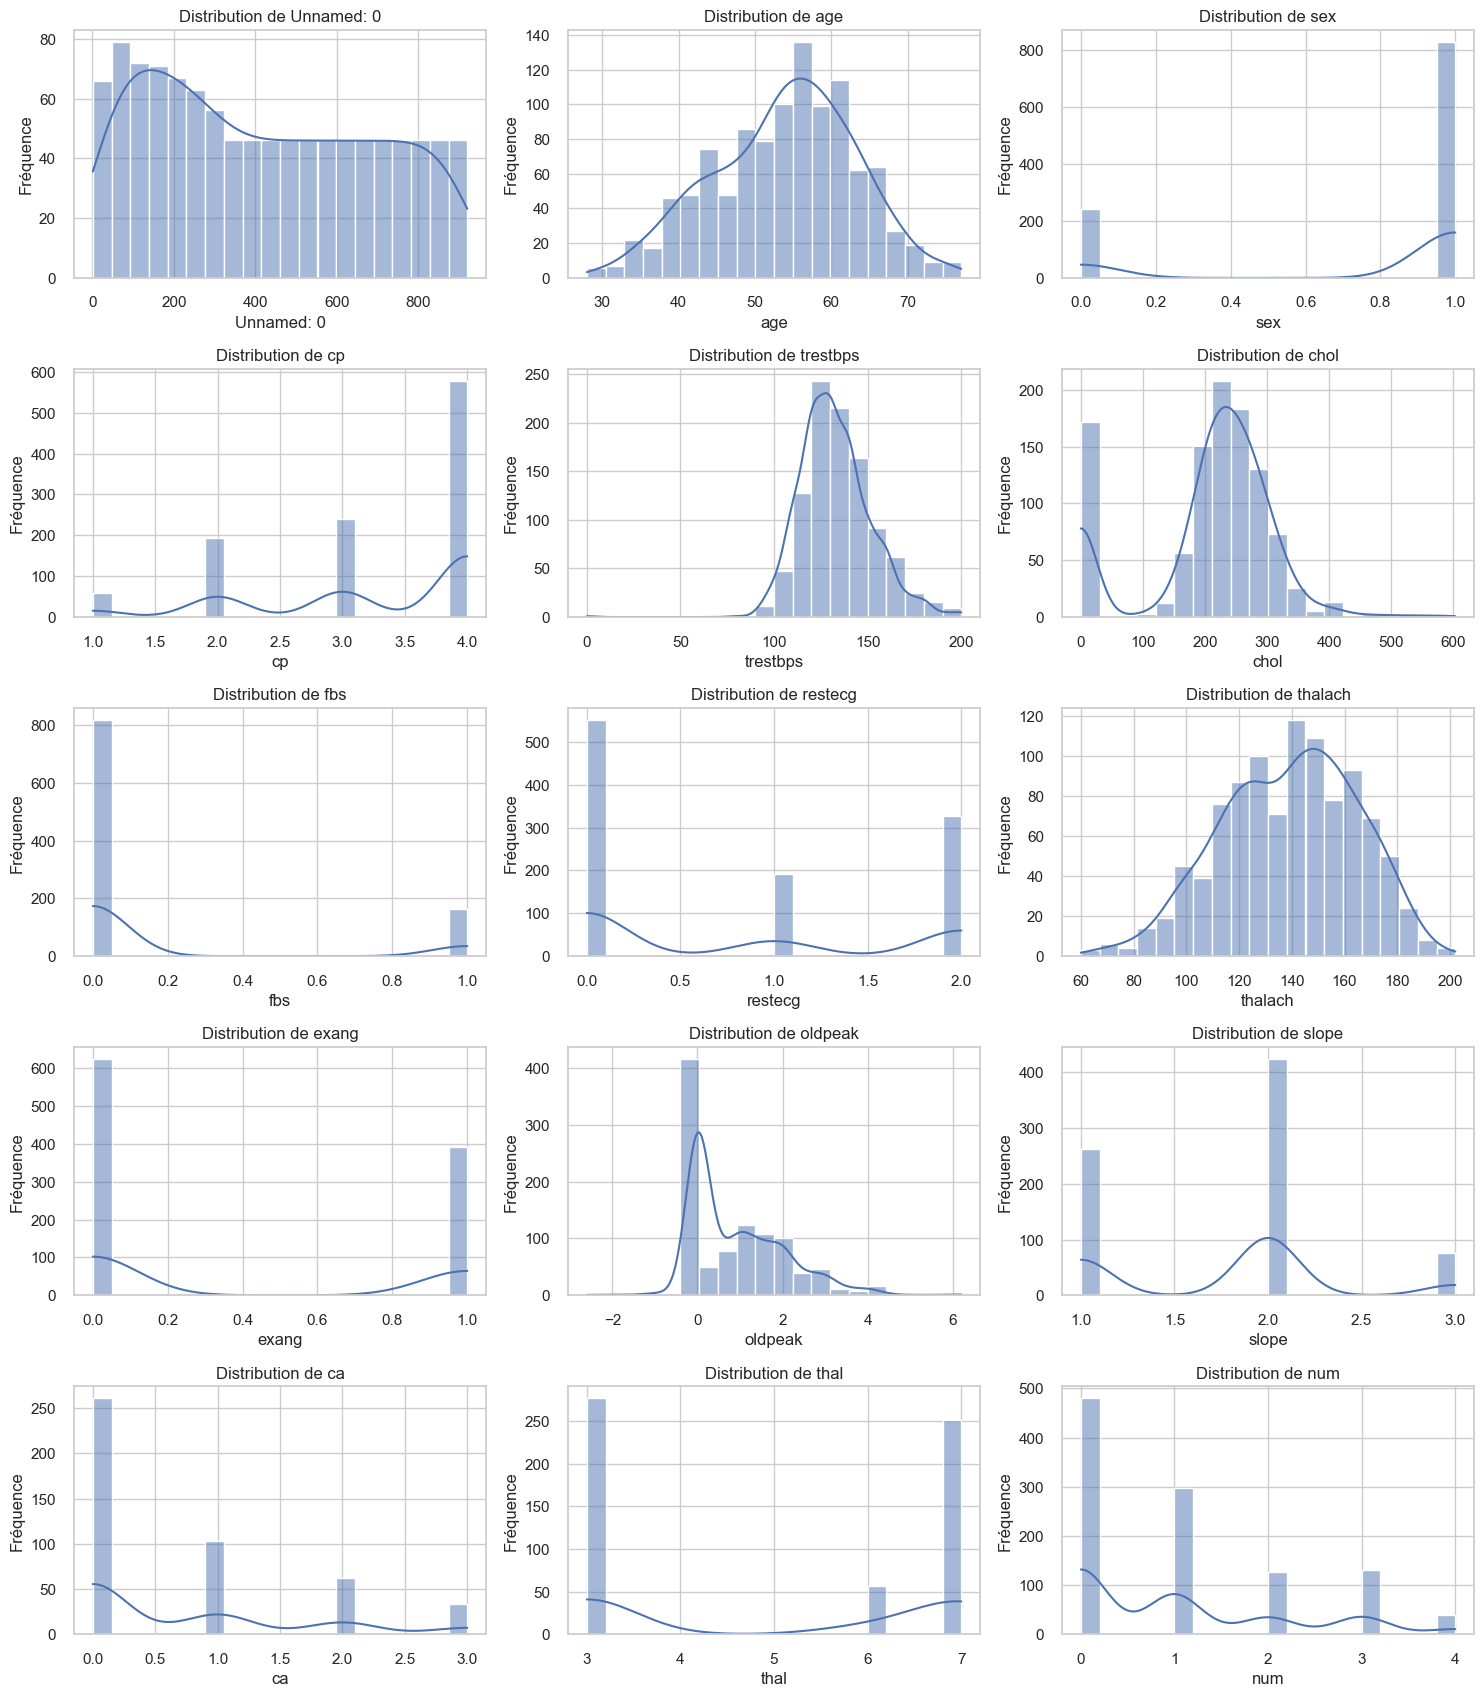

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner les colonnes numériques
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns

# Configuration de la grille de plots pour les distributions
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)
    sns.histplot(merged_df[col], kde=True, bins=20)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

 #### Catégoritielle

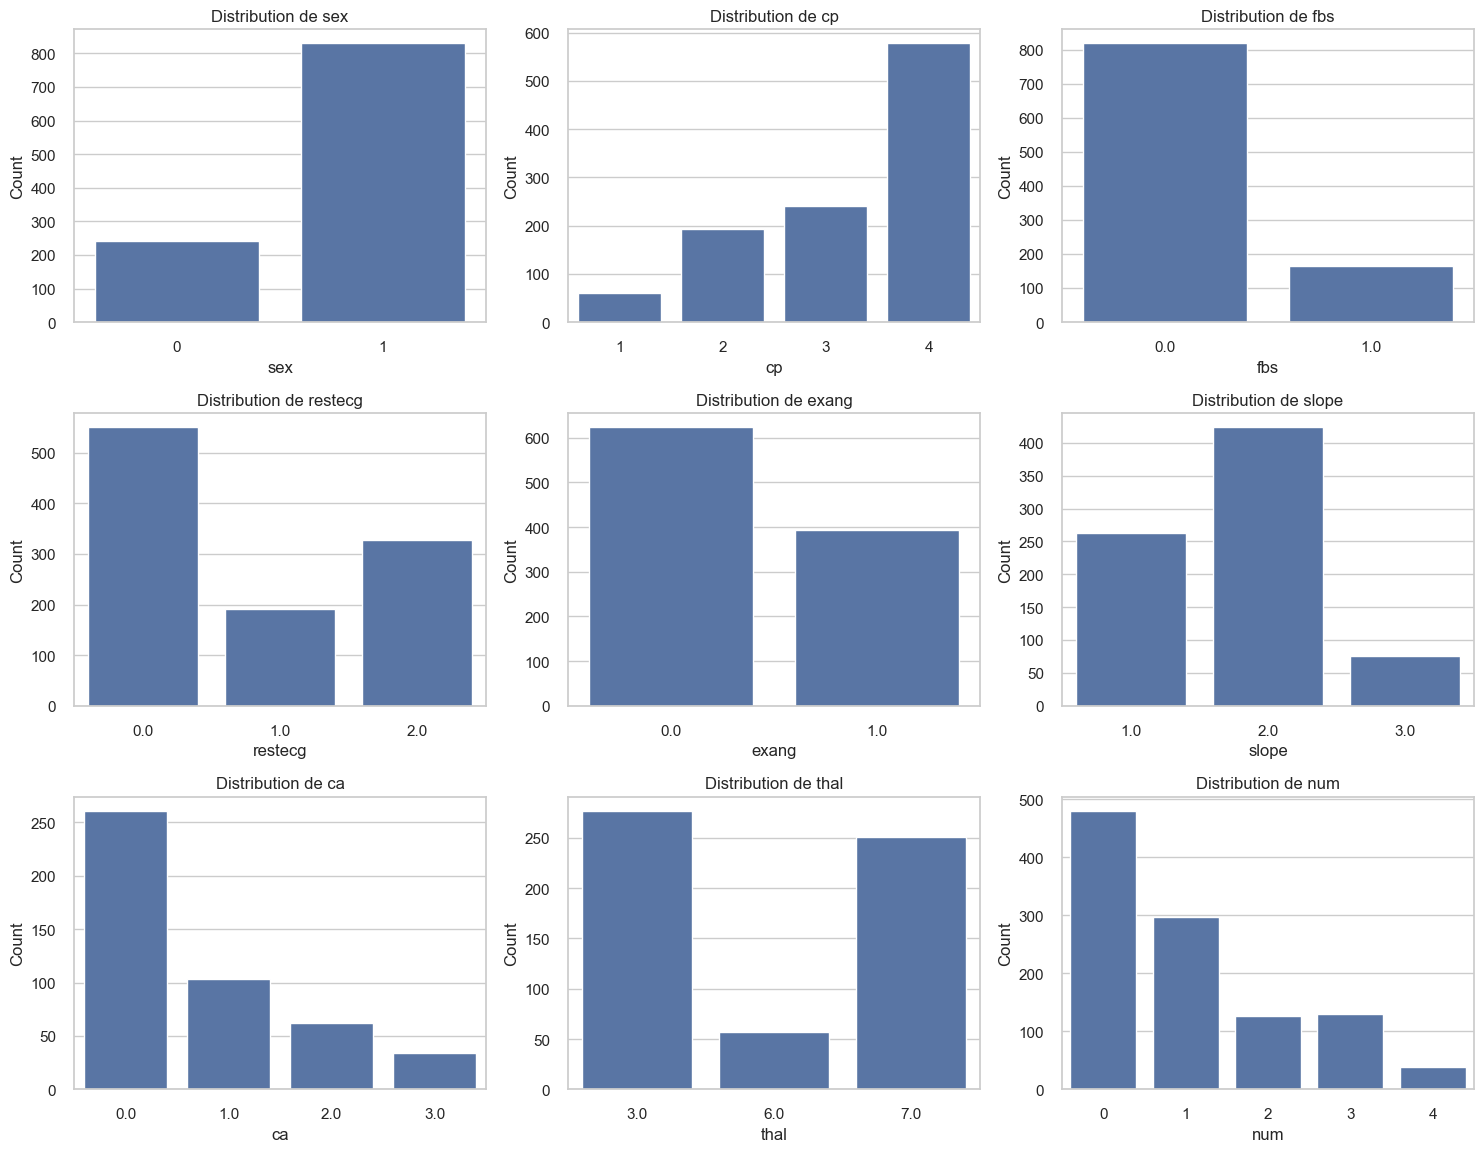

In [37]:
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'num']

# Configuration de la grille de plots
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns) // 3 + 1, 3, i)
    sns.countplot(data=merged_df, x=col)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

### Analyse Bivarié

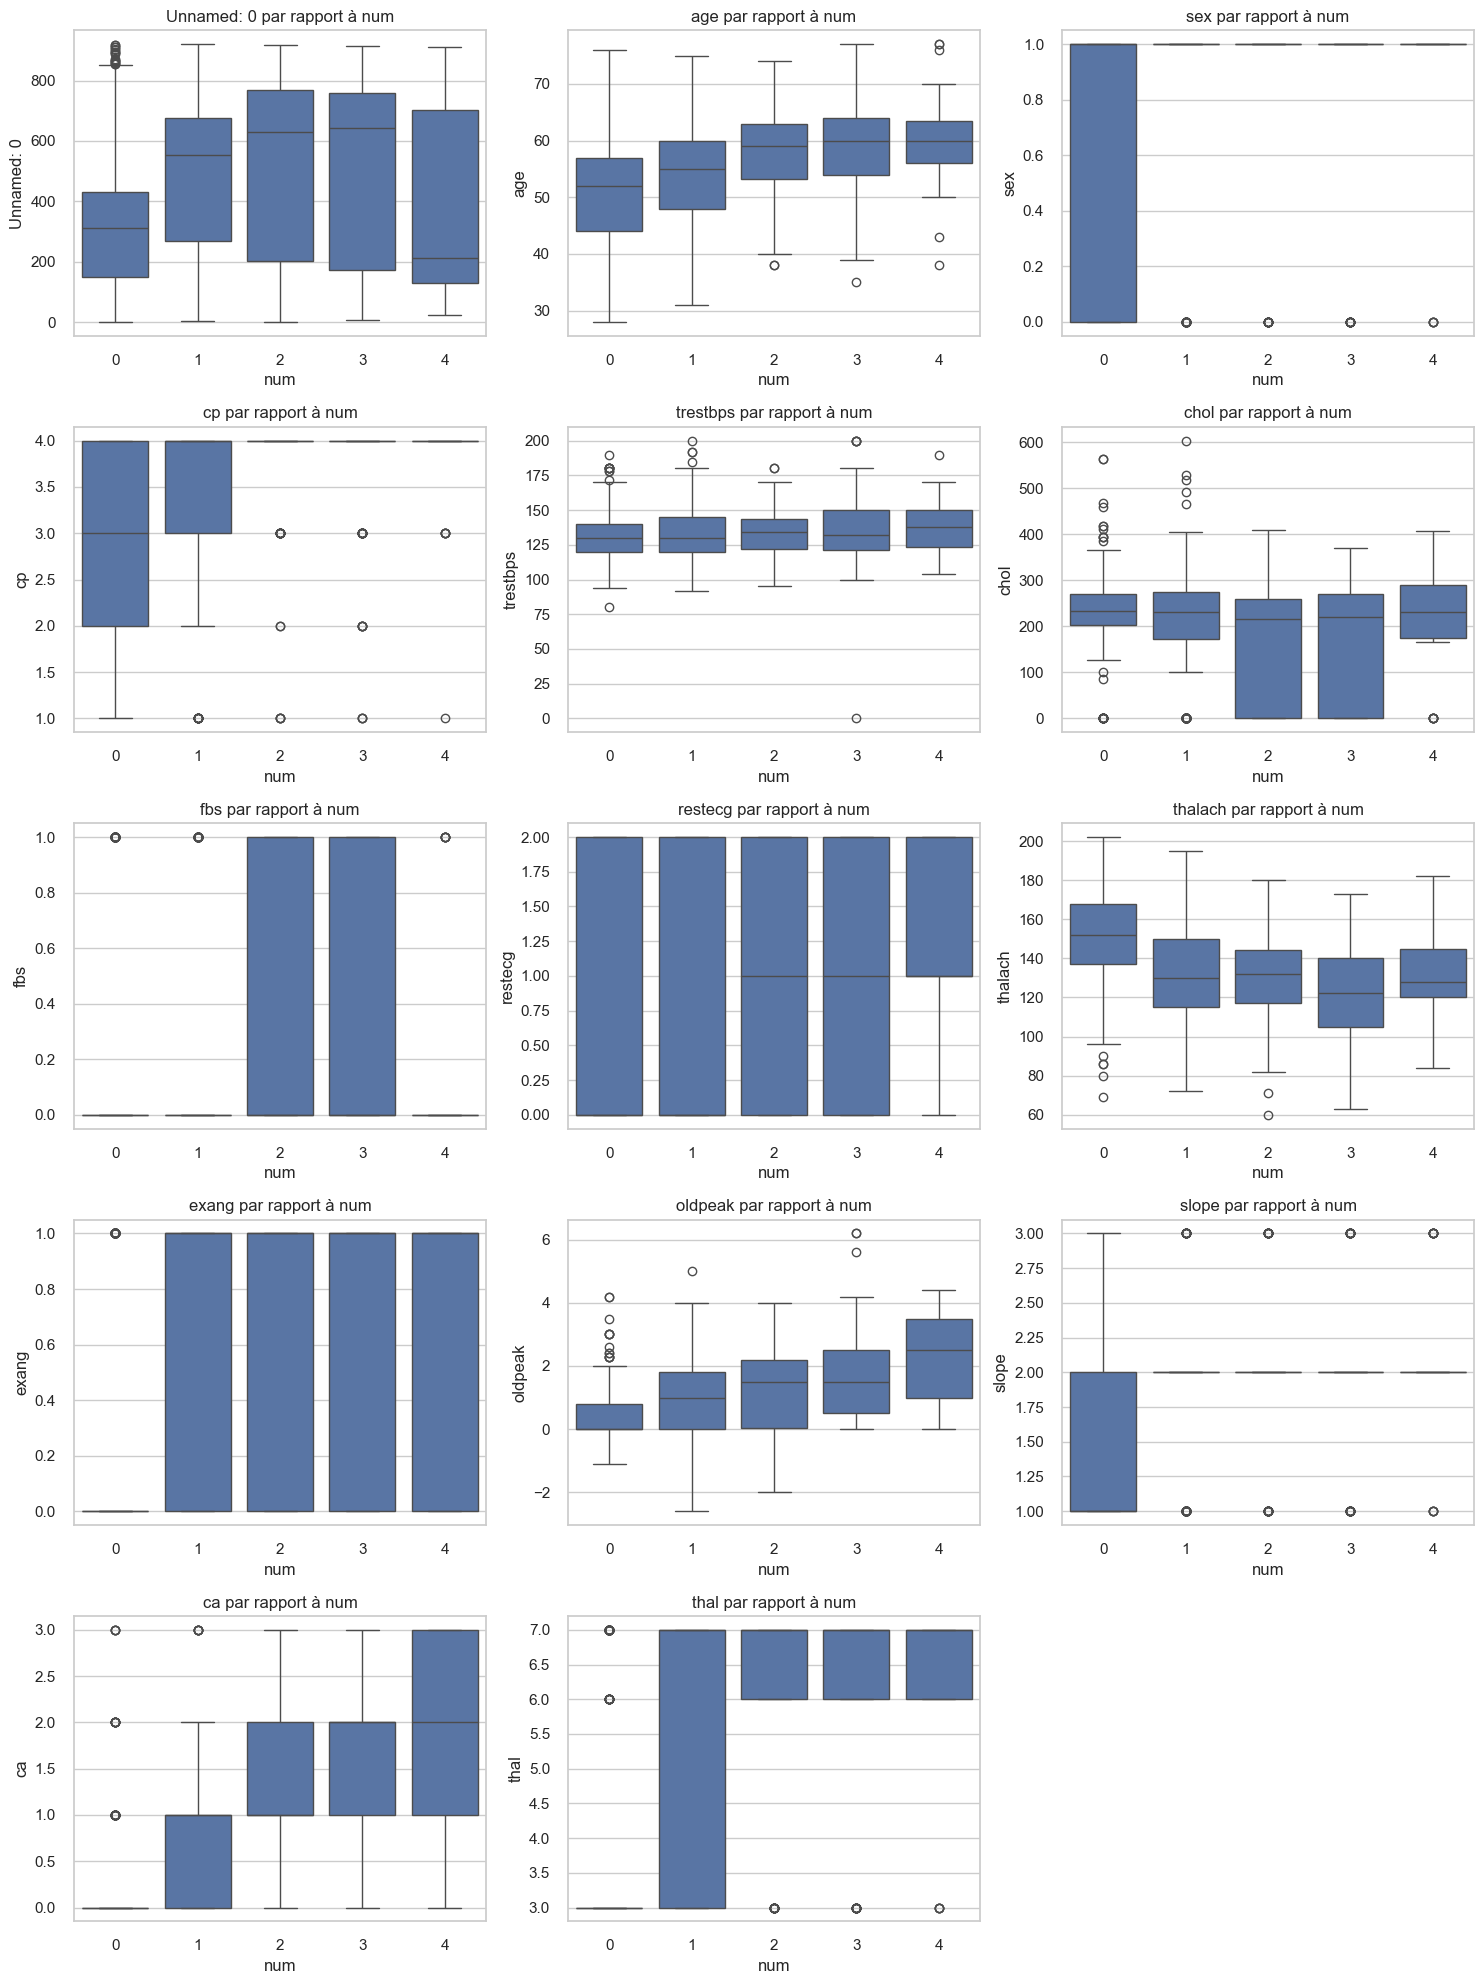

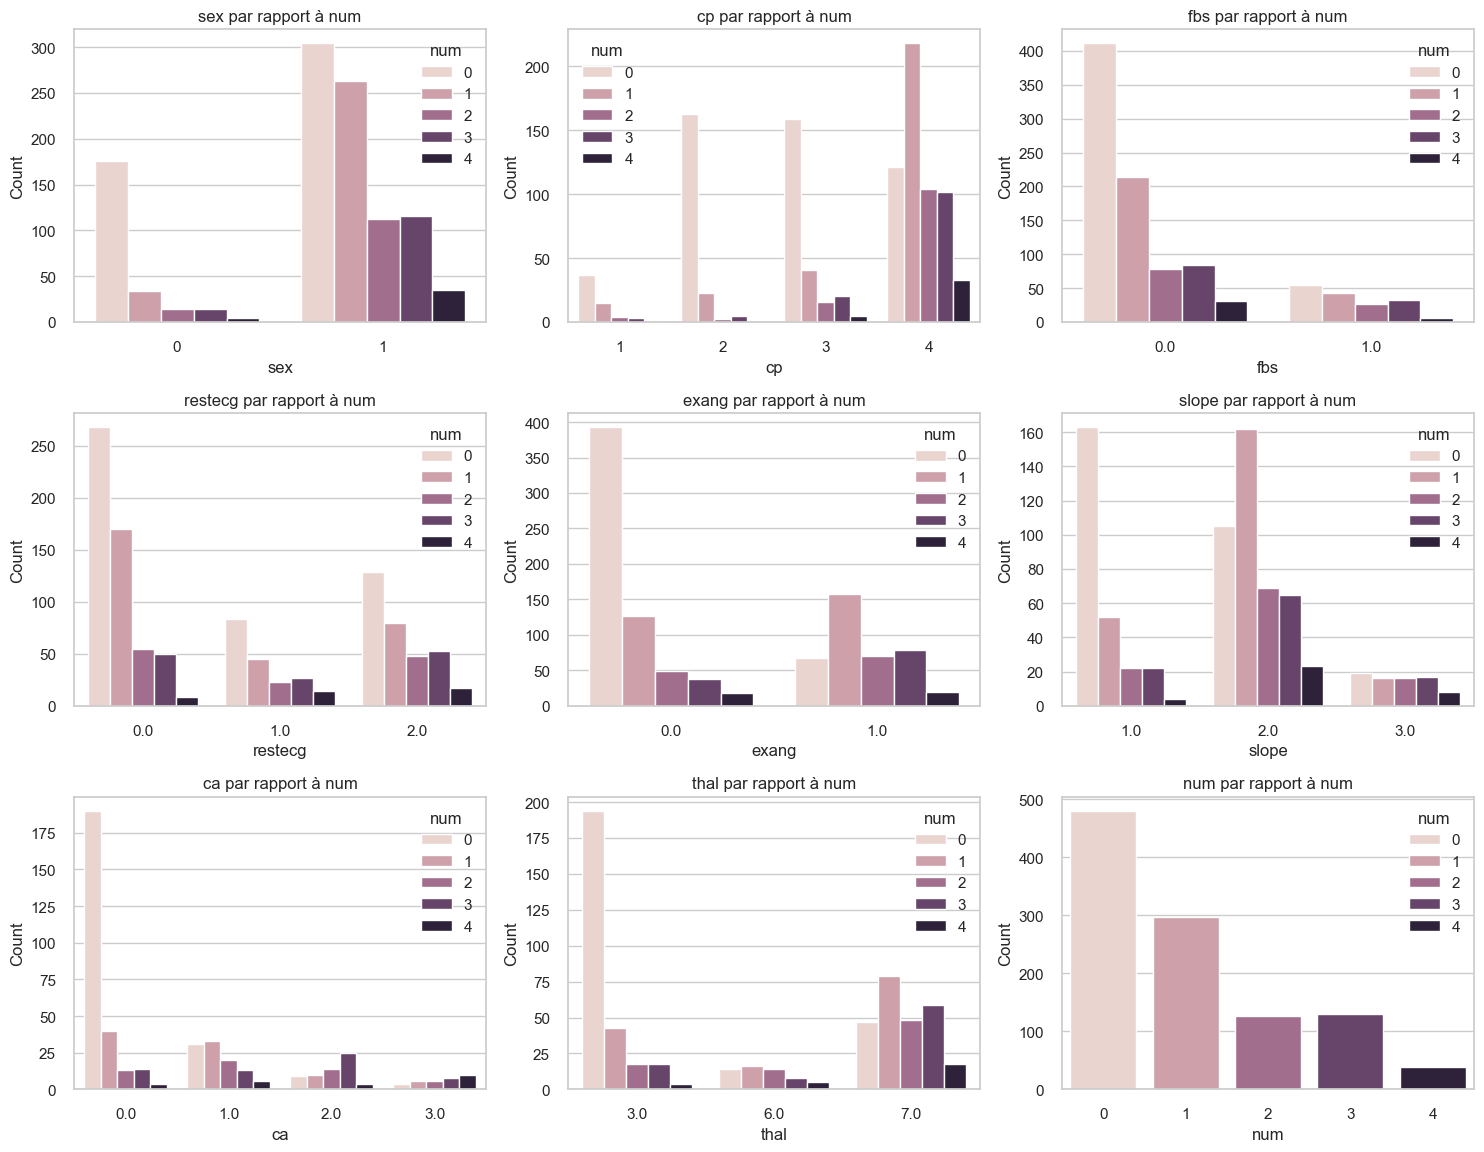

In [38]:
# Analyse bivariée avec la variable cible `num`
target_column = 'num'
numeric_features = merged_df.select_dtypes(include=['float64', 'int64']).columns.drop(target_column)

# Visualisation des variables numériques par rapport à la cible avec des boxplots
plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(len(numeric_features) // 3 + 1, 3, i)
    sns.boxplot(data=merged_df, x=target_column, y=col)
    plt.title(f"{col} par rapport à {target_column}")
    plt.xlabel(target_column)
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# Visualisation des variables catégorielles par rapport à la cible avec des countplots
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns) // 3 + 1, 3, i)
    sns.countplot(data=merged_df, x=col, hue=target_column)
    plt.title(f"{col} par rapport à {target_column}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


### Suite à l'observation : traitement des données

In [39]:
merged_df.dtypes

Unnamed: 0      int64
age             int64
sex             int64
cp              int64
trestbps      float64
chol          float64
fbs           float64
restecg       float64
thalach       float64
exang         float64
oldpeak       float64
slope         float64
ca            float64
thal          float64
num             int64
dtype: object

### Transforme data

Choix de l'imputation et du scaler:

L'imputation KNN a été choisi afin de conserver la distribution ainsi que la relation entre les colonnes. en effet, nous nous basons sur la positions des points dans l'espace et la distance entre ces derniers: cela est la stratégie adaptée car les disstributions ne respectent pas la loi Gaussienne

RobustScaler est préféré dans ce contexte parce qu’il est moins sensible aux valeurs extrêmes (outliers). Contrairement à StandardScaler, qui utilise la moyenne et l’écart-type, RobustScaler se base sur la médiane et les quartiles. Cela permet d'avoir une distribution normalisée tout en réduisant l'impact des valeurs anormalement élevées ou basses, ce qui est pertinent pour des variables comme chol ou oldpeak, qui peuvent présenter des valeurs extrêmes.

Cette préparation rend les données homogènes et prêtes pour une analyse de classification sans distorsion excessive due aux outliers.

In [42]:


# Copier le dataframe pour éviter de modifier l'original
df_processed = merged_df.copy()

# Étape 1 : Imputation des valeurs manquantes avec KNN
# Imputation uniquement sur les colonnes numériques (float64 et int64)
imputer = KNNImputer(n_neighbors=5)
df_processed.iloc[:, :] = imputer.fit_transform(df_processed)

# Étape 2 : Standardisation des données avec RobustScaler pour limiter l'influence des outliers
# Utiliser RobustScaler sur toutes les colonnes pour harmoniser les échelles
scaler = RobustScaler()
df_processed.iloc[:, :] = scaler.fit_transform(df_processed)

# Afficher le dataset final traité
print("Dataset après imputation et standardisation :")
print(df_processed.head())

# Vérifier les valeurs manquantes après l'imputation
print("\nValeurs manquantes restantes :")
print(df_processed.isnull().sum())


Dataset après imputation et standardisation :
   Unnamed: 0       age  sex  cp  trestbps      chol  fbs  restecg   thalach  \
0   -0.799791  0.653061    0  -3  0.728155  0.036036  1.0      0.5  0.270270   
1   -0.797706  0.979592    0   0  1.456311  0.672673  0.0      0.5 -0.864865   
2   -0.795620  0.979592    0   0 -0.485437 -0.012012  0.0      0.5 -0.297297   
3   -0.793535 -1.469388    0  -1  0.000000  0.240240  0.0      0.0  1.270270   
4   -0.791449 -1.142857   -1  -2  0.000000 -0.312312  0.0      0.5  0.864865   

   exang  oldpeak     slope        ca  thal  num  
0    0.0   0.9375  1.666667 -0.666667  0.00 -0.5  
1    1.0   0.4375  0.000000  1.833333 -0.75  0.5  
2    1.0   1.1250  0.000000  1.000000  0.25  0.0  
3    0.0   1.6875  1.666667 -0.666667 -0.75 -0.5  
4    0.0   0.3750 -1.666667 -0.666667 -0.75 -0.5  

Valeurs manquantes restantes :
Unnamed: 0    0
age           0
sex           0
cp            0
trestbps      0
chol          0
fbs           0
restecg       0
thalach

C:\Users\yskon\AppData\Local\Temp\ipykernel_18508\1635987974.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.79979145 -0.79770594 -0.79562044 ... -0.18873827 -0.18248175
 -0.17205422]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_processed.iloc[:, :] = scaler.fit_transform(df_processed)
C:\Users\yskon\AppData\Local\Temp\ipykernel_18508\1635987974.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.65306122 0.97959184 0.97959184 ... 0.65306122 0.32653061 0.16326531]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_processed.iloc[:, :] = scaler.fit_transform(df_processed)
C:\Users\yskon\AppData\Local\Temp\ipykernel_18508\1635987974.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pand

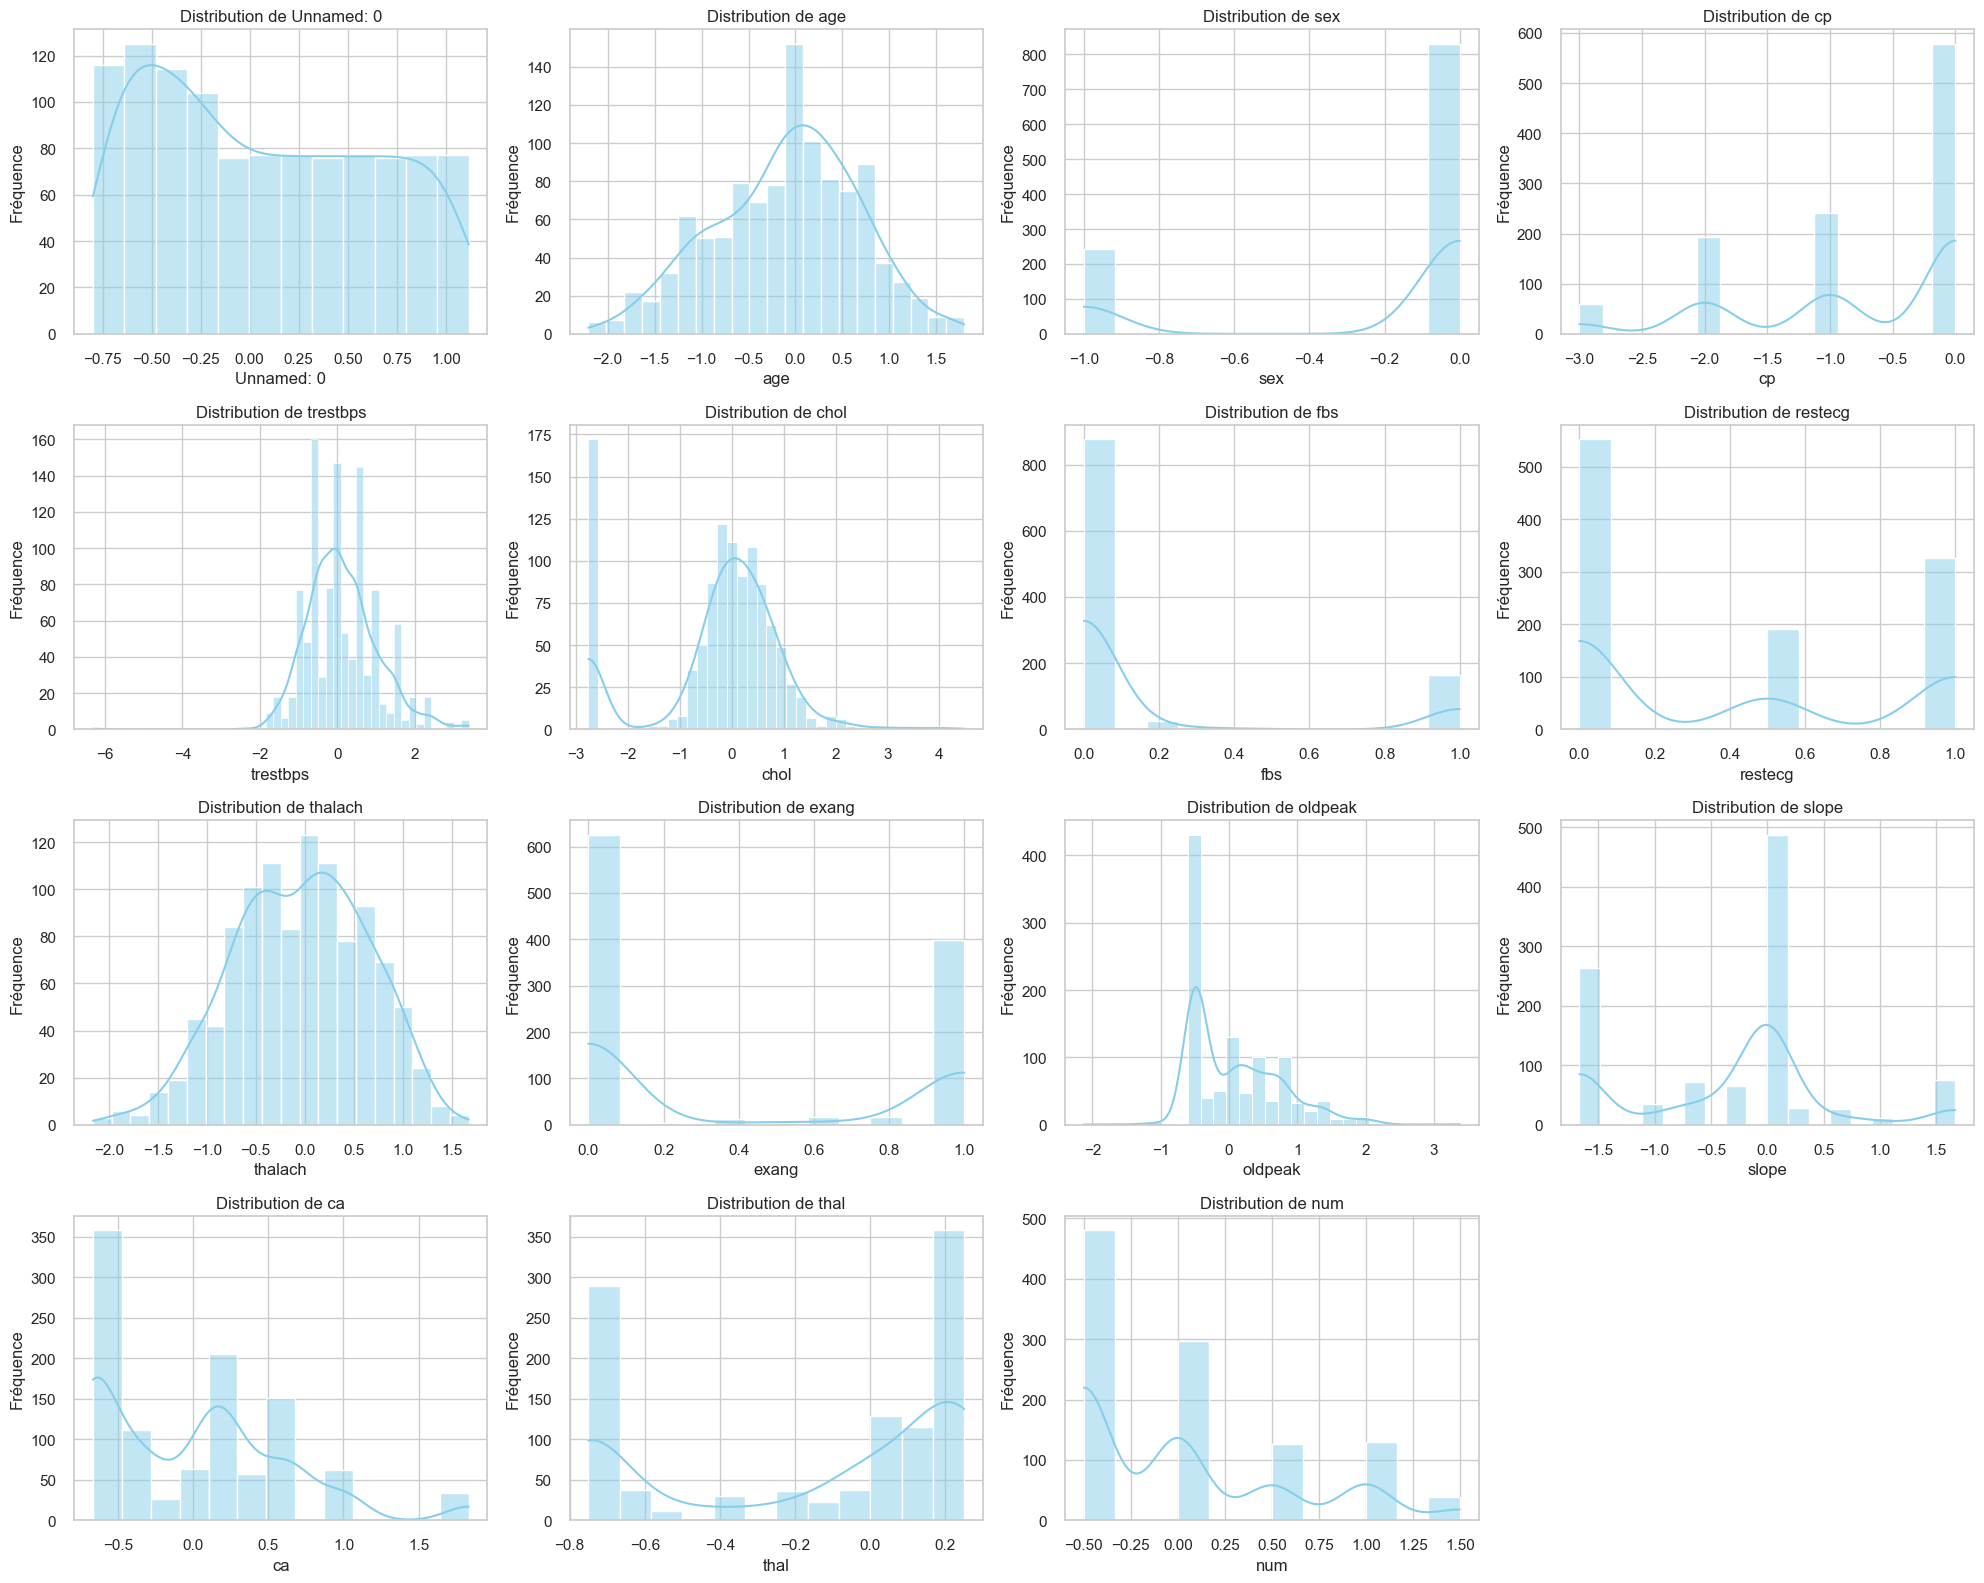

In [43]:
# Configurer le style de visualisation
sns.set(style="whitegrid")

# Créer une grille de sous-plots pour afficher les distributions
num_columns = df_processed.shape[1]
num_rows = (num_columns + 3) // 4  # 4 graphiques par ligne
fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))
axes = axes.flatten()

# Afficher la distribution de chaque colonne
for i, col in enumerate(df_processed.columns):
    sns.histplot(df_processed[col], kde=True, ax=axes[i], color="skyblue")
    axes[i].set_title(f"Distribution de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Fréquence")

# Supprimer les axes inutilisés s'il y en a
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()